In [1]:
import cv2 as cv
import numpy as np
import utilities
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import NoNorm
import scipy as sp
import os
import configparser
from PIL import Image, ImageDraw
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
import matplotlib.patches as patches

# 0. Loading data and parameters

In [2]:
# Insert path + filename here:
path = "examples/lattice_extraction/SrTiO3(001)/"
filename = "small_SrTiO3_1244.png"

In [3]:
inputfile = path + filename
path, fname, extension = utilities.get_filename_parts(inputfile)

if os.path.isfile(path+"parameters.ini"):
    conf = configparser.ConfigParser(allow_no_value=True)
    conf.read_file(open(path+"parameters.ini"))
    
    # [SIFT]
    cThr = conf.getfloat('SIFT', 'cThr', fallback=0.003)
    sigma = conf.getfloat('SIFT', 'sigma', fallback=4)
    nOctLayers = conf.getint('SIFT', 'nOctLayers', fallback=8)
    
    # [Keypoint filtering]
    size_Threshold = conf.getfloat('Keypoint filtering', 'size_Threshold', fallback=2)
    edge_Threshold = conf.getfloat('Keypoint filtering', 'edge_Threshold', fallback=1)
    
    # [Keypoint Clustering]
    clustering_span_kp = range(conf.getint('Keypoint Clustering', 'cluster_kp_low',
                                           fallback=2),
                               conf.getint('Keypoint Clustering', 'cluster_kp_high',
                                           fallback=12))
    cluster_choice = conf.getint('Keypoint Clustering', 'cluster_choice', fallback=1)
    
    # [Nearest Neighbours]
    cluster_kNN_low = conf.getint('Nearest Neighbours', 'cluster_kNN_low', fallback=6)
    cluster_kNN_high = conf.getint('Nearest Neighbours', 'cluster_kNN_high', fallback=24)
    cluster_span_kNN = range(cluster_kNN_low, cluster_kNN_high)
    clustersize_Threshold = conf.getfloat('Nearest Neighbours', 'clustersize_Threshold',
                                          fallback=0.3)
    
    # [Sublattice Lookup]
    clustering_span_SUBL = range(conf.getint('Sublattice lookup', 'cluster_SUBL_low',
                                         fallback=2),
                          conf.getint('Sublattice lookup', 'cluster_SUBL_high',
                                      fallback=6))
    
    # [Deviation plot]
    k2 = conf.getint('Deviation plot', 'k2', fallback=10)
    rtol_rel = conf.getfloat('Deviation plot', 'rtol_rel', fallback=4)
    arrow_width = conf.getfloat('Deviation plot', 'arrow_width', fallback=0.003)
    c_max_arrow = conf.getfloat('Deviation plot', 'c_max_arrow', fallback=None)

    
else:       # DO NOT MODIFY! Default values here, modify the parameters.ini file if needed.
    # [SIFT]
    cThr = 0.003
    sigma = 4
    nOctLayers = 8
    
    # [Keypoint filtering]
    size_Threshold = 2
    edge_Threshold = 1

    # [Keypoint Clustering]
    clustering_span_kp = range(2, 12)
    cluster_choice = 1
    
    # [Nearest Neighbours]
    cluster_kNN_low = 6
    cluster_kNN_high = 24
    cluster_span_kNN = range(cluster_kNN_low, cluster_kNN_high)
    clustersize_Threshold = 0.3

    # [Sublattice lookup]
    clustering_span_SUBL = range(2, 6)

    # [Deviation plot]
    k2 = 10
    rtol_rel = 4
    arrow_width = 0.003
    c_max_arrow = None


print("These values will be used for the analysis:")
print('cThr:', cThr)
print('sigma:', sigma)
print('nOctLayers:', nOctLayers) 
print('size_Threshold:', size_Threshold)
print('edge_Threshold:', edge_Threshold )
print('clustering_span_kp:', clustering_span_kp)
print('cluster_choice:', cluster_choice)
print('cluster_kNN_low:', cluster_kNN_low)
print('cluster_kNN_high:', cluster_kNN_high)
print('clustersize_Threshold:', clustersize_Threshold)
print('clustering_span_SUBL:', clustering_span_SUBL)
print('k2:', k2)
print('rtol_rel:', rtol_rel)
print('arrow_width:', arrow_width)
print('c_max_arrow:', c_max_arrow)

These values will be used for the analysis:
cThr: 0.003
sigma: 4.0
nOctLayers: 8
size_Threshold: 2.0
edge_Threshold: 1.0
clustering_span_kp: range(2, 12)
cluster_choice: 1
cluster_kNN_low: 6
cluster_kNN_high: 24
clustersize_Threshold: 0.3
clustering_span_SUBL: range(2, 6)
k2: 10
rtol_rel: 4.0
arrow_width: 0.003
c_max_arrow: None


# 1. Getting keypoints via Scale-Invariant-Feature-Tranform(SIFT)

In this section we apply SIFT over the input image, extracting keypoints and descriptors.
**SIFT** extracts the features and computes their descriptors. It utilizes several *Difference of Gaussian* (DoG) filters at multiple scales to detect blobs/features in the image. After the detection a descriptor is generated for all of them. SIFT descriptors encode the local intensity gradient environment surrounding a keypoint. Gradients within a certain pixel around the keypoint are weighted and combined into a single 128 dimensional vector. The weights are chosen in such a way depending on the scale at which the keypoint was found, making the descriptors themselves invariant under scaling. Rotation invariance is achieved by constructing a local coordinate frame on top of the keypoint, taking into account the directions of the gradients. 

Nice minimal intros at: <br>
(Good theory): https://courses.cs.washington.edu/courses/cse576/11sp/notes/SIFT_white2011.pdf <br>
(Documentation): https://docs.opencv.org/4.5.4/d7/d60/classcv_1_1SIFT.html <br>

Secondary sources: <br>
(Basic intro): https://www.geeksforgeeks.org/sift-interest-point-detector-using-python-opencv/ <br>
(Good theory and examples, alt.): https://www.analyticsvidhya.com/blog/2019/10/detailed-guide-powerful-sift-technique-image-matching-python/ <br>
(YouTube videos): https://www.youtube.com/watch?v=KgsHoJYJ4S8&list=PL2zRqk16wsdqXEMpHrc4Qnb5rA1Cylrhx&index=12 <br>
(Descriptors comparison): https://www.techgeekbuzz.com/sift-feature-extraction-using-opencv-in-python/ <br>

Image to be inspected:


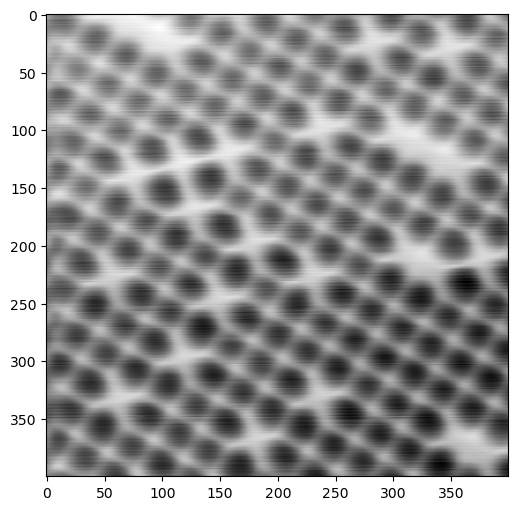

In [4]:
img = cv.imread(inputfile)
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
gray_original = gray

print("Image to be inspected:")
plt.figure(figsize=(6,6), dpi=100, facecolor="w", edgecolor="k")
gray_cmap = utilities.get_correctGreyCmap("greyscale")
plt.imshow(gray, cmap=gray_cmap, vmin=0, vmax=255)
plt.savefig(path+"original_gray.svg")
plt.show()

The next cell is where SIFT is applied for the first and last time, meaning that no new keypoints will be extracted other than these. [SIFT] parameters in the *parameters.ini* file must be set such that the majority of the features is detected (e.g. atoms, vacancies). If features far bigger or smaller than average are detected, the overall prediction won't usually be affected since such features will be filtered out. <br>

**[SIFT] parameters suggestions**. <br>
See the [documentation](https://github.com/QuantumMaterialsModelling/AiSurf-Automated-Identification-of-Surface-images/blob/master/README.md) for a brief description of the parameters. <br>
- *cThr*. Stay around the default value of 0.003, which is low enough to capture weak features that will be discarded later on;
- *sigma*. Very important parameter; on the practical side lowering the sigma will detect smaller keypoints, which can be useful for some images. The default value of 4 is an intermediate setting; this is the first parameter to be modified among the three as it greatly affects the prediction;
- *nOctLayers*. Increasing its value allows to detect keypoints more accurately, but missing some important features usually won't affect the lattice prediction. The default value of 8 is typically high, but fits for several situations. If low-contrast but desired features disappear during the analysis, try lowering this value. For low-noise images, a value of 3 can work.

Threshold: 0.003 
Sigma: 4.0 
Number of octave layers: 8


[ WARN:0@29.000] global shadow_sift.hpp:13 SIFT_create DEPRECATED: cv.xfeatures2d.SIFT_create() is deprecated due SIFT tranfer to the main repository. https://github.com/opencv/opencv/issues/16736


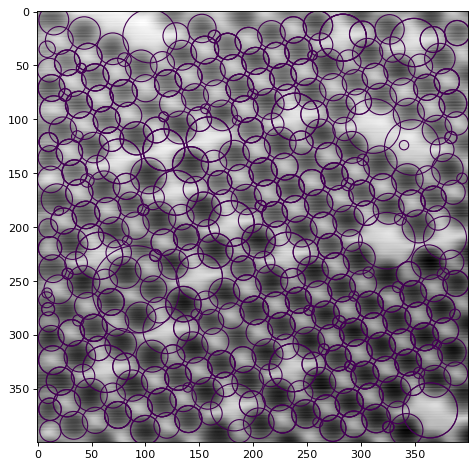

In [5]:
# SIFT application:
print('Threshold:', cThr, '\nSigma:', sigma, '\nNumber of octave layers:', nOctLayers)

sift = cv.xfeatures2d.SIFT_create(contrastThreshold=cThr, sigma=sigma,
                                  nOctaveLayers=nOctLayers)
kp = sift.detect(gray, None)
utilities.plot_clusters(np.array(gray_original), kp, labels=np.zeros(np.size(kp)), fill=False,
                        colormap="viridis")

## 1.5 Preliminary cleaning

The sizes of the atomic blobs that we are interested in may all be quite similar. SIFT detects features of different sizes which can lead to the identification of very large or small unphysical keypoints that don't describe the features of interest anymore. <br>
To solve this issue we focus on a smaller range of sizes around the median of all detected keypoints. This is done *before* any clustering process. <br>
**[Keypoint_filtering] parameters suggestions**: <br>
- *size_Threshold*: usually between 1.5 and 2.5, its tuning depends on the image and the SIFT predictions. Leaving the default value of 2 is usually sufficient.
- *edge_Threshold*: leaving the default value of 1 is recommended, the final prediction won't be affected much by this parameter.

In [6]:
sizes = [kp[i].size for i in range(np.size(kp))]
size_med = np.median(sizes)
kp = list(kp) 
wrongsize_index = [i for i in range(np.size(kp))\
                   if kp[i].size>size_Threshold*size_med or kp[i].size<size_med/size_Threshold
                  ]
wrongsize_index.reverse()
for i in wrongsize_index:
    del kp[i]    

Keypoints that are on the corner of the image are sometimes not correctly positioned, so they get removed. The size of this corner depends both on the median size of the features and *edge_threshold* parameter.

In [7]:
border = edge_Threshold*size_med
edgeKP_indices = []
for i in range(np.size(kp)):
    if (kp[i].pt[0]<border or kp[i].pt[0]>np.shape(gray)[1]-border or\
        kp[i].pt[1]<border or kp[i].pt[1]>np.shape(gray)[0]-border):
        edgeKP_indices.append(i)
edgeKP_indices.reverse()
for i in edgeKP_indices:
    del kp[i]

If two keypoints have the same xy coordinates, the first one is deleted.

In [8]:
kp, des_with_rot_inv = sift.compute(gray, kp) # ~Atomtype Identification better result when
                                              # doing descriptors before removing same-x kp.
kp = list(kp)
x = np.array([kp[i].pt for i in range(np.size(kp))])
x, uniqueXindices = np.unique(x, return_index=True, axis=0)

for i in range(np.size(kp)-1, -1, -1):
    if i not in uniqueXindices:
        del kp[i]

sizes = [kp[i].size for i in range(np.size(kp))]

After cleaning:


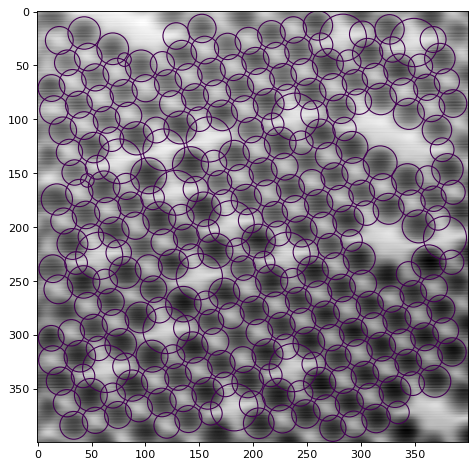

Distribution of the keypoints sizes (post-filtering):


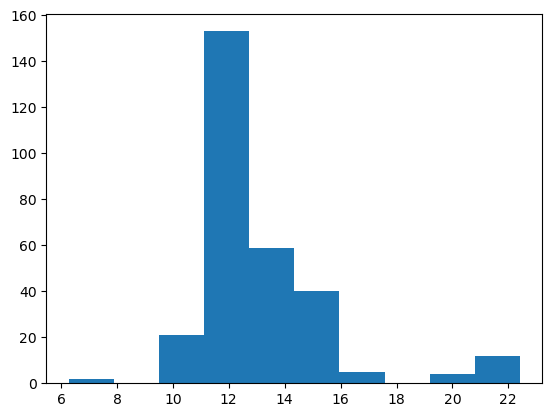

In [9]:
print('After cleaning:')
utilities.plot_clusters(np.array(gray_original), kp, labels=np.zeros(np.size(kp)), fill=False,
                        colormap="viridis")
plt.show()

print('Distribution of the keypoints sizes (post-filtering):')
plt.figure()
plt.hist(sizes)
plt.show()

# 2. Clustering the keypoints based on their descriptors

Descriptors are then clustered using [AgglomerativeClustering](https://towardsdatascience.com/agglomerative-clustering-and-dendrograms-explained-29fc12b85f23). The precise number of clusters we need is not known a priori, thus we evaluate the quality of the clustering by computing its [silhouette score](https://towardsdatascience.com/silhouette-coefficient-validating-clustering-techniques-e976bb81d10c), which measures simulaneously the self-similarity of each cluster and the difference between pairs of clusters. A perfect clustering yields a silhouette score of 1, whereas the worst possible score is -1. <br>
We visualize the found clustering that maximizes the silhouette score by drawing colored circles on top of the image, where each color corresponds to a different cluster. The radius of each circle corresponds to the scale at which SIFT found the keypoint. <br>
**[Keypoint clustering] parameters suggestions:** <br>
- *cluster_kp_low* and *cluster_kp_high*: keep the default values of (2, 12), it's unlikely that an image will contain more different types of features. It is probable that the predicted optimal number of clusters will be higher than the real human-recognized one: this is positive for the algorithm because it ensures that keypoints belonging to the same cluster likely correspond with the same feature. At this stage of the analysis it is not required to detect the correct number of clusters, but at the same time the prediction of a much larger number of clusters than the real one may lead to an incorrect analysis, so do not set the upper bound too high;
- *cluster_choice*: the default value of *1* selects the most populated cluster, but sometimes good predictions are made by choosing the second most populated one.

It is first needed to compute the descriptors. To break the rotational invariance and compare keypoints that might have different local coordinate directions, set all these angles/directions to 0:

In [10]:
for i in range(np.size(kp)):
    kp[i].angle = 0

kp, des = sift.compute(gray,kp)

In [11]:
labels = utilities.find_best_clustering(des, span=clustering_span_kp,
                              sklearn_clustering=AgglomerativeClustering)

Maximal silhouette score found with 11 clusters:
sil_score = 0.2590838372707367


Below are all keypoints plotted, colored according to their label. The size of the circle is the scale at which the keypoint was found.

Clusters visualization:


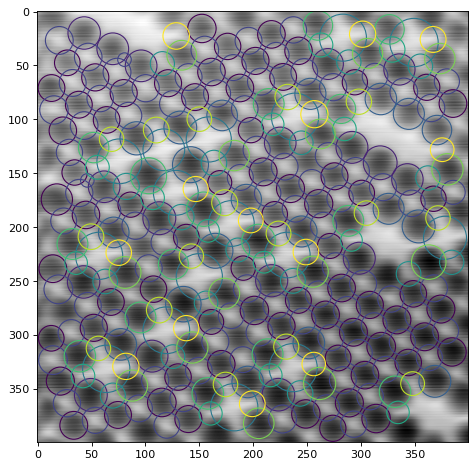

In [12]:
print('Clusters visualization:')
utilities.plot_clusters(np.array(gray_original), kp, labels, fill=False, colormap="viridis")
plt.savefig(path+"clustered_kps.svg")
plt.show()

This first clustering process is needed to detect the most populated cluster, to be used as a reference to detect the other sublattices. As mentioned, there are usually some equivalent lattice sites which are differently labelled. If this happened there is no need to re-tune the previous parameters.

**Extra:** If the user would you like to visualize some clusters of their choice, the following two cells will allow to do so.

In [13]:
print("Different available labels:", np.unique(labels))

Different available labels: [ 0  1  2  3  4  5  6  7  8  9 10]


Chosen clusters (display only), with different colors and not:


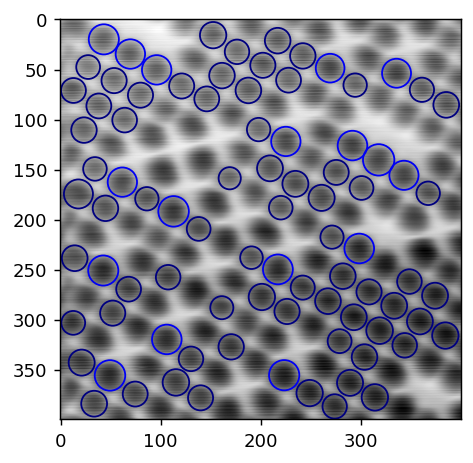

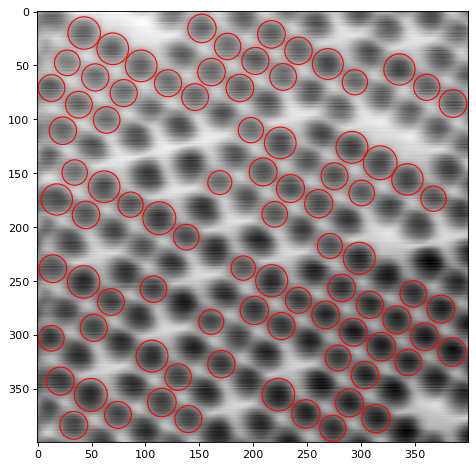

In [14]:
# chosen_labels used for vacancy selection
chosen_labels = [0, 1]  # Put here the labels of the clusters you want to visualize

kps_filtered, labels_filtered = utilities.clusters_selector(kp, labels, chosen_labels)
print("Chosen clusters (display only), with different colors and not:")

fig=plt.figure(figsize=(4,4), dpi=130, facecolor='w', edgecolor='k')
for i in chosen_labels:   
    utilities.plot_one_cluster(np.array(gray_original), kp, labels, i, fill=False)
    
utilities.plot_clusters(np.array(gray_original), kps_filtered, labels=np.zeros(np.size(kps_filtered)),
                                        fill=False, colormap='bwr')
# plt.savefig(path+"chosen_clusters.svg")

# 3.Extracting Lattice Vectors

To extract the lattice vectors, we **select the reference cluster**. The user can choose the reference cluster by setting the parameter *cluster_choice* (as mentioned above), but it is recommended to choose the first or second most populated one.

Sorted clusters' population: [85, 69, 19, 17, 17, 16, 16, 16, 14, 14, 13]
Pop. of the chosen cluster: 85

Chosen reference cluster:


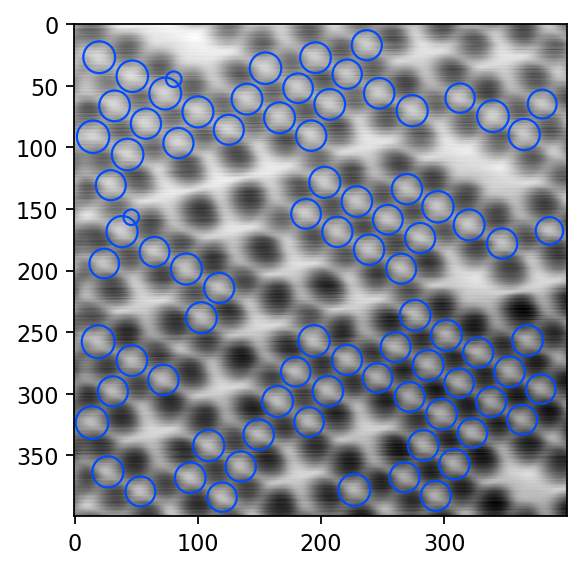

In [15]:
# Setting the reference cluster:
bins = np.bincount(labels)
bins = list(bins)
bins_old = bins
ref_cluster = cluster_choice -1
bins = sorted(bins, reverse=True)
print('Sorted clusters\' population:', bins)

lab_max = bins[ref_cluster]
print('Pop. of the chosen cluster:', lab_max)
for i in range(len(bins)):
    if bins_old[i] == lab_max:
        l_max = i
        break

fig=plt.figure(figsize=(4,4), dpi=160, facecolor='w', edgecolor='k')
utilities.plot_one_cluster(np.array(gray_original), kp, labels, l_max, fill=False)
print('\nChosen reference cluster:')
plt.savefig(path+"single_cluster.svg")
plt.show()

Save the reference cluster's coordinates:


In [ ]:
# labels of the reference cluster, rewrite in a more readable way
pts = np.float64([key_point.pt for key_point in kp]).reshape(-1, 1, 2)
pts = pts[labels==l_max]

with open(path+'atom_coordinates.txt', 'w') as writer:
    for i in range(len(pts)):
        coord = str(pts[i,0,0])+', '+str(pts[i,0,1])+'\n'
        writer.write(coord)

If we focus on the regular circles, the primitive lattice vectors correspond to their first nearest neighbours. Let's calculate the first few nearest neighbours for all of these keypoints and view the resulting plot. <br>
**[Nearest neighbours] parameters suggestions:** <br>
- *cluster_kNN_low*: This parameter both corresponds to the KNN to calculate, and the minimum number of clusters on the NN plot. Usually the default value of 6 is enough, as the silhouette score will define the optimal number of NN anyway;
- *cluster_span_kNN*: usually keep the default interval from cluster_kNN_low to 4\*cluster_kNN_low; 
- *clustersize_Threshold*: the most 'rare' detected nearest neighbours are discarded, since they are probably misclassified keypoints. Usually keep the default value of 0.3, meaning that only the clusters with *population $\geq$ max_populated_cluster\*clustersize_Threshold* will be considered.

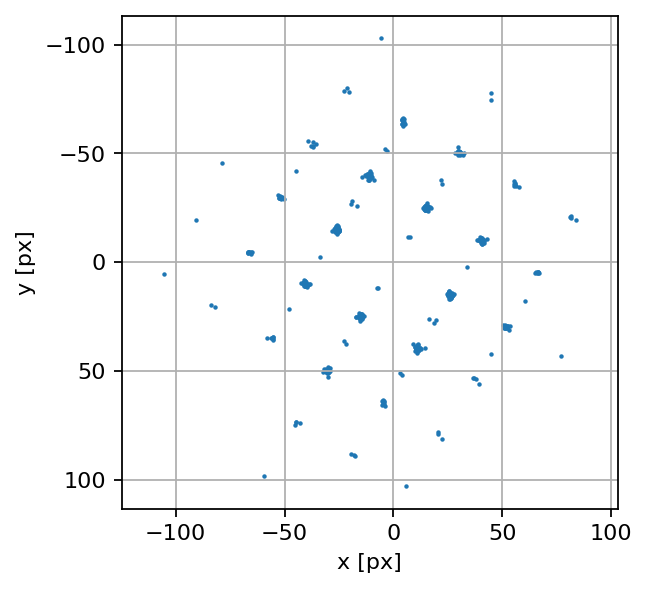

In [16]:
x = np.array([kp[i].pt for i in range(np.size(kp))]) # kp coordinates
x_ofMaxCluster = np.unique(x[labels==l_max,:], axis=0)
x = np.unique(x, axis=0)
kNN = utilities.kNearestNeighbours(x_ofMaxCluster, cluster_kNN_low)

plt.figure(figsize=(4,4), dpi=160)
plt.axis("equal")
plt.gca().invert_yaxis()
plt.grid()
plt.scatter(kNN[:,0], kNN[:,1], s=1)
plt.xlabel("x [px]")
plt.ylabel("y [px]")
plt.savefig(path+"NNV_original.svg")
plt.show()

Above you can see the distribution of the detected nearest neighbors positions for each keypoint of the reference cluster. We also have some noise that comes from erroneously labeled keypoints.<br>
To extract the primitive lattice vectors we want to choose two linearly independent peaks with the least combined arc length. However, there will be a nearest neighbour at both +**a** and -**a** for any lattice vector **a**. To eliminate this ambiguity, we mirror all nearest Neighbours that lie in negative x direction through the origin.

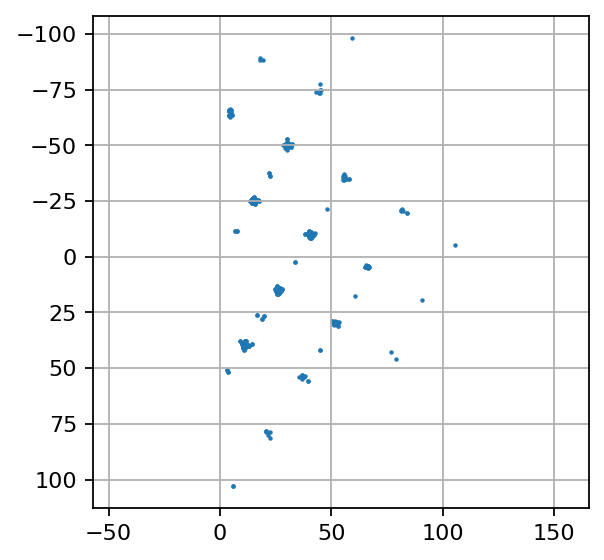

In [17]:
kNN_posX = np.array([-kNN[i,:] if kNN[i,0]<0 else kNN[i,:] for i in range(np.shape(kNN)[0])])

plt.figure(figsize=(4,4), dpi=160)
plt.axis("equal")
plt.gca().invert_yaxis()
plt.grid()
plt.scatter(kNN_posX[:,0], kNN_posX[:,1], s=1)
plt.show()

Now to get the peak positions we cluster the obtained nearest neighbours distance distribution and calculate the average position of each cluster. To get the right number of clusters we can reuse find_best_clustering() from before.
To eliminate the small noisy clusters that might be placed near to the origin we will only consider peaks which have sufficiently many points around them.

In [18]:
print("Clustering NNV's of maximally represented feature class:")
kNN_labels = utilities.find_best_clustering(kNN_posX, span=cluster_span_kNN)

#The potential lattice vectors are the average vectors of each cluster:
average_peaks = np.array(
    [np.average(kNN_posX[kNN_labels==l,:], axis=0) for l in set(kNN_labels)])

Clustering NNV's of maximally represented feature class:
Maximal silhouette score found with 23 clusters:
sil_score = 0.9016814594043665


Further reduce these vectors based on how big the found clusters are to prevent noise-derived small clusters near the origin to mess with the result. This is done by using *clustersize_Threshold*.

Primitive vectors coordinates:
a = ( 15.07 +/- 0.66,-25.04 +/- 0.64)
b = ( 25.95 +/- 0.65, 15.01 +/- 0.79)


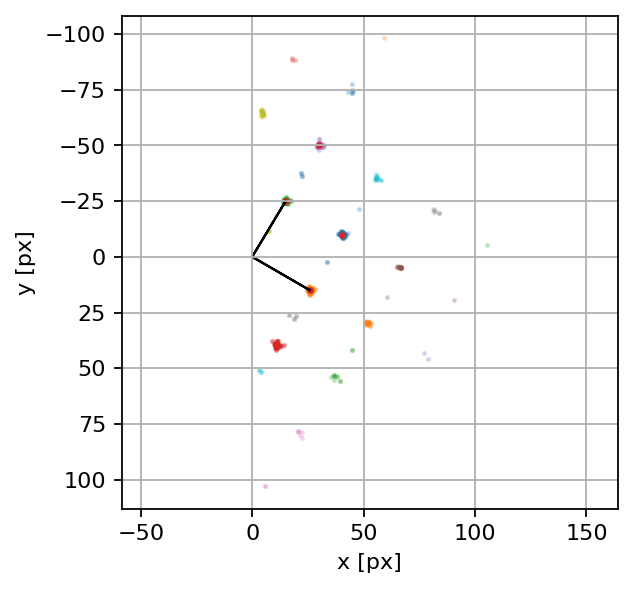

In [19]:
clustersizes = np.array([len(kNN_labels[kNN_labels==i]) for i in range(max(kNN_labels)+1)])
max_clustersize = np.max(clustersizes)
average_peaks = average_peaks[clustersizes>=max_clustersize*clustersize_Threshold,:]
labels_AP=np.arange(
            max(set(kNN_labels))+1)[clustersizes>=max_clustersize*clustersize_Threshold]

# Find primitive lattice vectors
sorted_ind = np.argsort(np.linalg.norm(average_peaks, axis=1))
average_peaks = np.take_along_axis(average_peaks,
                                   sorted_ind.repeat(2).reshape(np.shape(average_peaks)),
                                   axis=0)
labels_AP = np.take_along_axis(labels_AP, sorted_ind, axis=0)

found = False
for i in range(np.shape(average_peaks)[0]):
    if found == True:
        break  
    for j in range(i+1, np.shape(average_peaks)[0]):
        if np.abs(np.cos(utilities.angle_between(average_peaks[i,:],
                                                 average_peaks[j,:])))<0.95:
            a = average_peaks[i,:]
            b = average_peaks[j,:]
            cluster_a = labels_AP[i]
            cluster_b = labels_AP[j]
            found = True
            break
if found==False:
    print("Something went wrong ... a,b not found")

std_a = np.std(kNN_posX[kNN_labels==cluster_a,:], axis=0)
std_b = np.std(kNN_posX[kNN_labels==cluster_b,:], axis=0)

print("Primitive vectors coordinates:")
print("a = ({:6.2f} +/-{:5.2f},{:6.2f} +/-{:5.2f})\n\
b = ({:6.2f} +/-{:5.2f},{:6.2f} +/-{:5.2f})".\
      format(a[0], std_a[0], a[1], std_a[1], b[0], std_b[0], b[1], std_b[1]))


plt.figure(figsize=(4,4), dpi=160)
utilities.plot_clustered_NNVs(kNN_posX, kNN_labels, average_peaks, a, b)
plt.xlabel("x [px]")
plt.ylabel("y [px]")
plt.grid()
plt.savefig(path+"NNV_1cluster.svg")
plt.show()

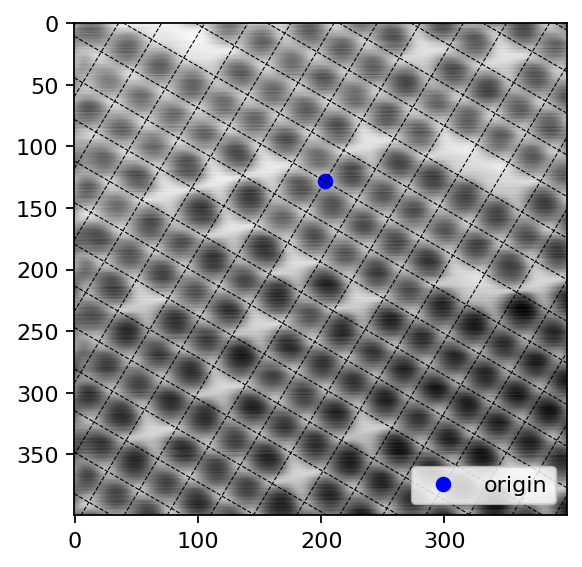

In [20]:
# Plot a grid overlay according to the predicted lattice
plt.figure(figsize=(4,4), dpi=160)
plt.imshow(gray_original, cmap=gray_cmap, norm=NoNorm())
utilities.plot_grid(x_ofMaxCluster[np.shape(x_ofMaxCluster)[0]//2,:], a, b, linewidth=0.5)
plt.savefig(path+"gridoverlay.svg")
plt.show()

# 4. Finding Sublattice Positions

Having found the primitive lattice vectors, we can go back and look at all our original keypoints again. In crystallography, a Bravais lattice is always made up of a lattice (i.e. the primitive lattice vectors) and a basis (i.e. sublattice positions). For one chosen lattice, we want to know where the rest of the keypoints are positioned within this lattice.<br>
This is now fairly straightforward to do. For any given keypoint we can look at its nearest lattice point and then transform it into that lattice points unit cell. The sublattice positions are obtained by clustering the points and calculating the center of mass of each cluster. This step assigns a label to each keypoint based on its sublattice position, and fixes the misclassifications present in the first clustering process.

**[Sublattice lookup] parameter suggestions**:
- *cluster_SUBL_low* and *cluster_SUBL_high*: the interval between the two contains the correct size of the basis. The default interval from 2 to 6 is wide enough and it will hardly needed to be changed. The optimal number of atoms in the basis will be found via silhouette score calculation anyway. Values used to calculate "clustering_span_SUBL".

Calculating distance matrix of folded back points ...
Done
Clustering keypoints based on their position in the lattice that has been found (i.e. sublattice found).
Maximal silhouette score found with 2 clusters:
sil_score = 0.8843682288619835


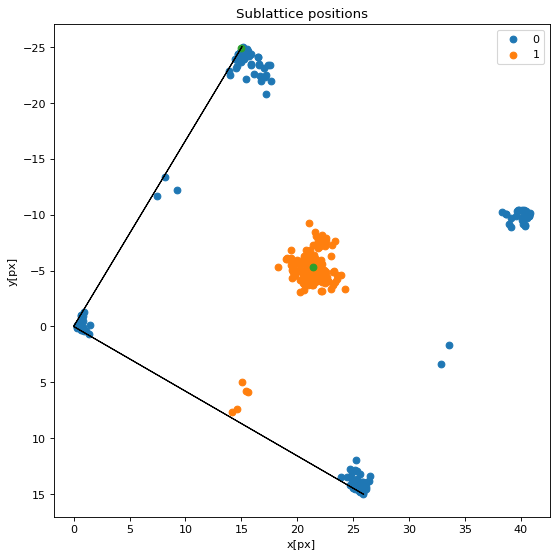

sublattice positions (in units of the lattice vectors):
[[0.99463518 0.        ]
 [0.52444955 0.51927298]]


In [21]:
subl, subl_labels = utilities.sublattice_lookup(x, x_ofMaxCluster, a, b, path, SUBLplot=True,
                                      possibleNoSubl=clustering_span_SUBL)
print("sublattice positions (in units of the lattice vectors):\n{}".format(subl))

It is important to know what elements of sublattice represent the same chemical element (or vacancy thereof). To determine this we  repeat a clustering of the initial keypoints but with rotation invariance included.
Since we know which keypoints represent the sublattice elements, we optimize for a clustering where each sublattice (found without rot.inv. descriptors) falls closest to one cluster with rot. inv. descriptors. <br>

We start by creating *labels_subl_no_rot*, which contains the labels of kp which descriptors **have** rotational invariance, but with the knowledge of the number of atomic species which has been just obtained. The '_no_rot' in the name is present because the atomic species have been found after breaking rotational invariance.

Maximal silhouette score found with 2 clusters:
sil_score = 0.13333387672901154
there are  98.62068965517241  percent atomtype  0  in sublattice  0  other way round:  89.93654127961459
there are  1.3793103448275863  percent atomtype  1  in sublattice  0  other way round:  1.4598433588075999
there are  10.596026490066226  percent atomtype  0  in sublattice  1  other way round:  10.06282979352331
there are  89.40397350993378  percent atomtype  1  in sublattice  1  other way round:  98.53942671951299
The plotted circles are predicted to belong to the same atomic species.
Optimizaion scores:  [0.15111470769288707]


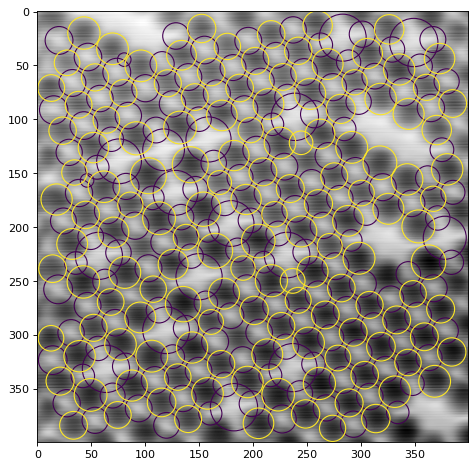

Maximal silhouette score found with 2 clusters:
sil_score = 0.17922325432300568
there are  74.82517482517483  percent atomtype  0  in sublattice  0  other way round:  86.9911626734742
there are  25.174825174825177  percent atomtype  1  in sublattice  0  other way round:  99.99722229938058
there are  100.0  percent atomtype  0  in sublattice  1  other way round:  13.008024325005488
there are  0.0  percent atomtype  1  in sublattice  1  other way round:  0.0
The plotted circles are predicted to belong to the same atomic species.
Optimizaion scores:  [0.15111470769288707, 0.3560257919260939]


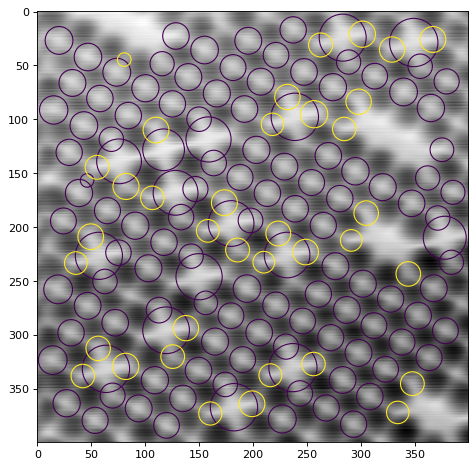

Maximal silhouette score found with 2 clusters:
sil_score = 0.1964854896068573
there are  100.0  percent atomtype  0  in sublattice  0  other way round:  2.7777391980666937
there are  0.0  percent atomtype  1  in sublattice  0  other way round:  0.0
there are  51.85185185185185  percent atomtype  0  in sublattice  1  other way round:  97.22087193233426
there are  48.148148148148145  percent atomtype  1  in sublattice  1  other way round:  99.9984615621298
The plotted circles are predicted to belong to the same atomic species.
Optimizaion scores:  [0.15111470769288707, 0.3560257919260939, 0.6809176411426013]


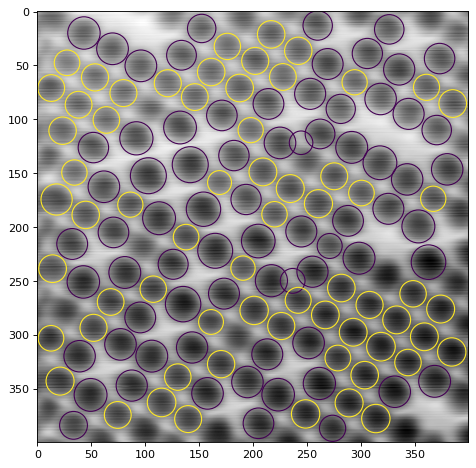

Atom types: [0, 1]


In [22]:
from scipy.spatial import distance

if len(subl) == 1:
# If only one type of kepyoint exists it has to be the same chemical element. 
    atomtypes = [0]
else:
# Otherwise we assume the number distinct elements to range from 1 to len(subl).
# We use the silhouette score to find an initial optimal rotation invariant clustering.
# The possibility that all keypoints are attributed to a chemical element is preserved
# since the highest fraction of all keypoints can fall into one rotation invariant cluster.
    if len(subl) == 2:
        atomtype_span = [2]
    else:
        atomtype_span = range(2, len(subl))

    des_with_rot_inv_sub = np.take(des_with_rot_inv, uniqueXindices, axis=0)
    labels_subl_no_rot = utilities.find_best_clustering(des_with_rot_inv, span=atomtype_span,
                                              sklearn_clustering=AgglomerativeClustering)
    labels_subl_no_rot = np.take(labels_subl_no_rot, uniqueXindices) #post-filtering kp
    # NOTICE: by def. labels_subl_no_rot HAS rot.inv. for the reasons explained above.

    # Temporary names.
    # They are subject to change in the repeated rotation invariant clustering.
    tmp_subl_labels = np.copy(subl_labels) #obtained w/o rot.inv
    tmp_kp = np.copy(kp) # // //
    tmp_labels_subl_no_rot = np.copy(labels_subl_no_rot)
    
    l = 0 # label counter
    results = []
# We optimize for a clustering where the sublattices fall closest into one rot. inv. cluster
    optimizationcheck = []
    # For the initial rotation inv clustering and each separate cluster independently
    while l < len(np.unique(labels_subl_no_rot)) + 1: #for each cluster (rot. inv. descriptors)
        results.append([])
        for k in range(len(np.unique(tmp_subl_labels))): #for each possible cell element
            sub_indices = np.where(tmp_subl_labels == k)
            total_size = len(sub_indices[0])
            results[l].append([])
            # For each rotation invariant cluster
            for i in range(len(np.unique(labels_subl_no_rot))):
                sub_no_rot_indices = np.where(tmp_labels_subl_no_rot == i)
                intersection = np.intersect1d(sub_indices, sub_no_rot_indices)
                fraction = np.divide(len(intersection), total_size)
                fraction_atom = len(intersection) / (len(sub_no_rot_indices[0])+0.001)
                results[l][k].append(fraction)
                print("there are ", fraction * 100, " percent atomtype ", i,
                      " in sublattice ", k, " other way round: ", fraction_atom * 100)
        # This optimization parameter approaches 0 the more the rotation invariant clusters
        # coincide with the sublattices.
        optimizationcheck.append(
            np.linalg.norm(
            distance.cdist( #axis=1 gives the 1d distances' array instead of the 2d matrix
                results[l], np.identity(len(np.unique(labels_subl_no_rot)))).min(axis=1)))  
        print("The plotted circles are predicted to belong to the same atomic species.")
        print("Optimizaion scores: ", optimizationcheck)
        
        utilities.plot_clusters(np.array(gray_original), tmp_kp,
                                tmp_labels_subl_no_rot, fill=False, colormap="viridis")
        plt.show()


        # A rotation invariant clustering is repeated inside every of the intitial clusters.
        # This allows for initially not distinguishable sublattices to be correctly identified
        # as distinct. Best shown in the Graphene 8x8nm, stiff tip, close.png where unrelated
        # keypoints prevent initial detection. The subclustering can find the finer difference
        # betweem carbon atoms and the empty space between.
        if l < len(np.unique(labels_subl_no_rot)): 
            des_tmp_subl_labels_with_rot_inv = np.take(des_with_rot_inv_sub,
                                               np.where(labels_subl_no_rot==l), axis=0)[0]
            tmp_kp = np.take(kp, np.where(labels_subl_no_rot==l))[0]
            tmp_subl_labels = np.take(subl_labels, np.where(labels_subl_no_rot==l))[0]
            tmp_labels_subl_no_rot = utilities.find_best_clustering(
                                            des_tmp_subl_labels_with_rot_inv, span=atomtype_span,
                                            sklearn_clustering=AgglomerativeClustering)
        l += 1


    best_candidate = np.nanargmin(optimizationcheck)
    atomtypes = [np.argmax(fractions) for fractions in results[best_candidate]]

print("Atom types:", atomtypes)

# 5. Deviations from periodicity

Having extracted the necessary bits of a periodic lattice, we can now visualise the deviations from this periodicity.<br>
**[Deviation plot] parameters suggestions:** <br>
- **k2**: number of nearest neighbors considered for each keypoint. *Default: 10*. You probably won't need to change this value;
- **rtol_rel**: all vectors that are within the relative_r-tolerance of the lattice vectors are drawn; *Default: 4 (pixels)*. Increasing this value will plot more arrows, and viceversa. It is the most important parameter among the four;
- **arrow_width**: the arrow_width can be specified (see [matplotlib.quiver() - width parameter](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.quiver.html)). *Default: 0.003*;
- **c_max_arrow**: it's a purely aesthetic parameter, tune it depending of the scale and preferences. For the images in this repository a value around 4 is sufficient.


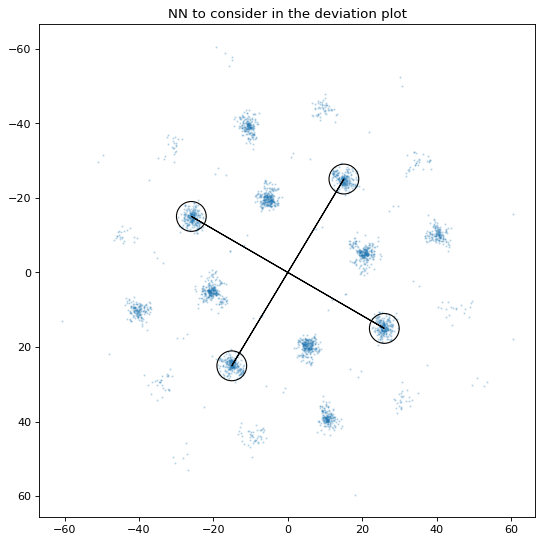

Sublattice 0:


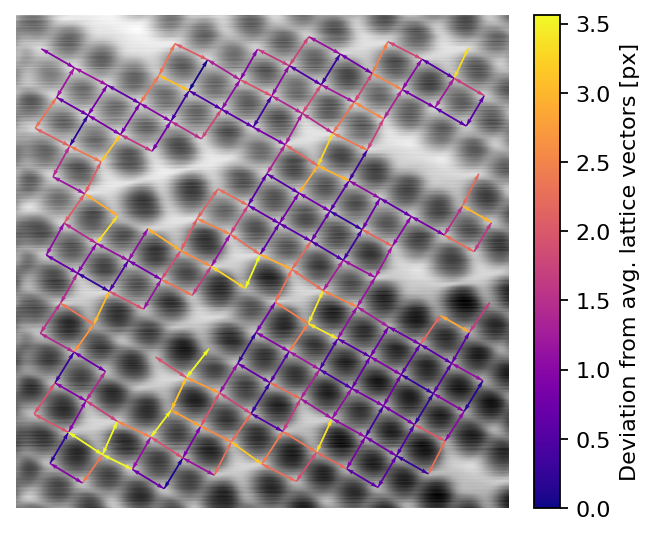

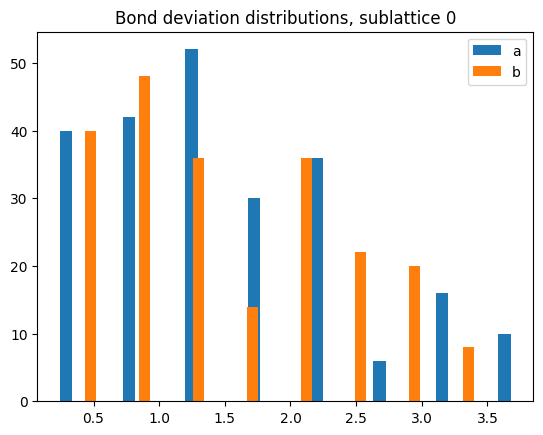

Sublattice 1:


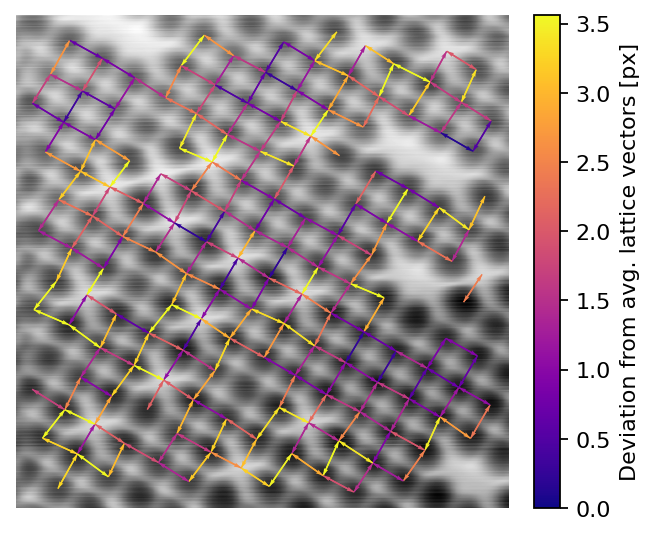

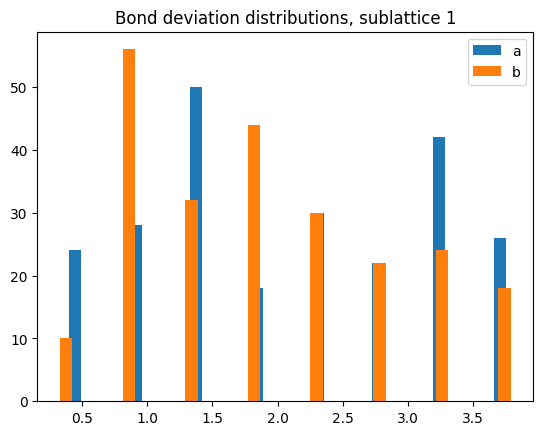

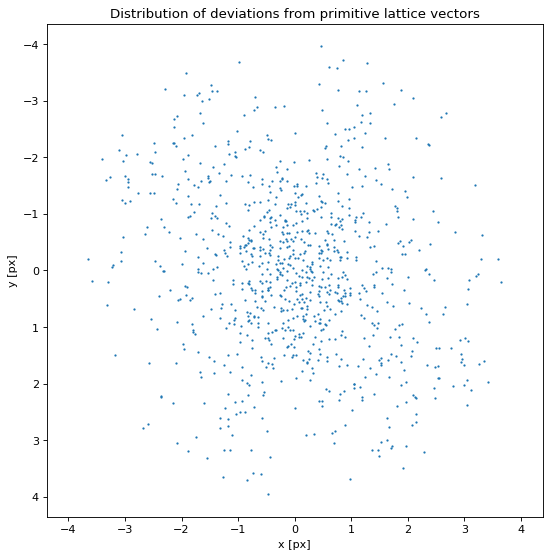

In [23]:
utilities.plot_lattice_deviations(x, a, b, subl_labels, k2, rtol_rel, path, arrow_width,
                                  gray_original, colorsmin=0, colorsmax=c_max_arrow)

Even if the calculations went well, it's possible that some atoms have not been correctly categorized. A better parameter tuning might make the situation better.

# 6. Lattice cell plot

If the calculations went well up to now, we have got all the informations to compute the average lattice cell.

In [24]:
lattice_complete = [[None]]*len(np.unique(atomtypes))
lattice_complete = np.array(lattice_complete)

for l in range(len(lattice_complete)): # loop over atomtypes
    # Center separate for each atomtype
    center_atom_cluster = np.where(np.array(atomtypes) == l)[0][0]
    lattice_complete = [[None]]*len(np.unique(atomtypes))

    for i in range(len(atomtypes)):
        if None in lattice_complete[atomtypes[i]]:
            lattice_complete[atomtypes[i]] = [np.array([0,0])] + subl[i][0]*a + subl[i][1]*b
        else:
            lattice_complete[atomtypes[i]] = np.append(lattice_complete[atomtypes[i]],
                                                       [np.array([0,0])] + subl[i][0]*a
                                                       + subl[i][1]*b, axis=0)
    lattice_construct = []

    for i in range(len(lattice_complete)):
        # Center the unit cell at the center_atom_cluster
        lattice_construct.append(lattice_complete[i] - (subl[center_atom_cluster][0]*a
                                                     + subl[center_atom_cluster][1]*b))
        for k in range(len(lattice_construct[i])): # Apply PBC
            lattice_construct[i][k] = utilities.Apply_PBC(a, b, lattice_construct[i][k])

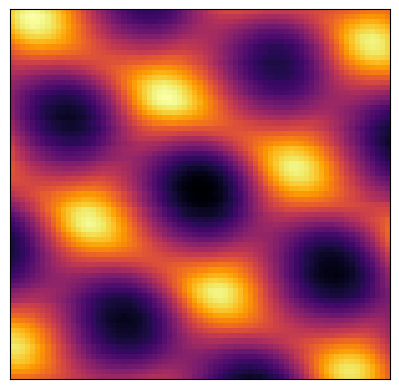

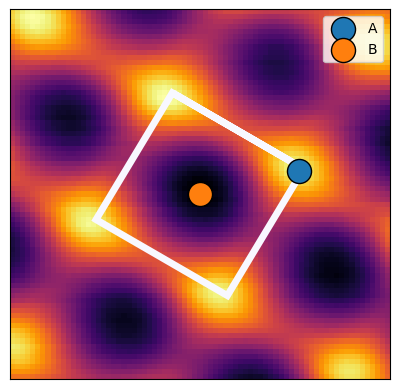

In [25]:
#Mean cell averaging
'''
With lengthener 1 only the unit cells are averaged and displayed.
With lengthener = 2 the average is done with twice as long unit vectors
and the surrounding area is included in the average.
'''
lengthener = 1.8 

##### Sum unit cells
#  Gives averaged view of lattice
avgImg, medianImg, width, height = utilities.average_cell(img, a, b, x, subl_labels,
                                                          center_atom_cluster, lengthener)

fig, ax = plt.subplots()
# To plot we need to invert y-axis
a[1] = -a[1]
b[1] = -b[1]
label = [["A", None, None, None], ["B", None, None, None], ["C", None, None, None]]
colors = ["tab:blue", "tab:orange", "tab:yellow"]

for i in range(len(lattice_complete)):
    self_trf_Index = 0
    for k in range(len(lattice_construct[i])):
        plt.scatter(lattice_construct[i][k][0], -lattice_construct[i][k][1], label=label[i][k],
                    marker="o", s=300, edgecolors='black', zorder=20)
        self_trf_Index += len(lattice_construct[i]) + 1   

ax.legend()
brillouin_zone_plot = np.array([(a+b)/2, (a-b)/2, -(a+b)/2, (-a+b)/2, (a+b)/2, (a-b)/2]) #to get pretty edges added one additional
patch = patches.PathPatch(matplotlib.path.Path(brillouin_zone_plot), alpha=1, lw=5, zorder=5, facecolor='none', edgecolor = "ghostwhite")
ax.add_patch(patch)

plt.imshow(avgImg, cmap="inferno", extent=[-width/2., width/2., -height/2., height/2. ])
plt.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, right=False, left= False, labelleft= False)
plt.savefig(path+"symmetry_cell_average.svg", bbox_inches='tight', dpi=200)

# Keep the next two lines in case of cell refresh
a[1] = -a[1]
b[1] = -b[1]